# Illustration of Expectation Maximization for Gaussian Mixture Models (GMMs)

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* Expectation-Maximization (EM) algorithm to perform soft-clustering on a toy dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# initialize random seed to have reproducible results
np.random.seed(1)

Generate an exemplary data set. Here, we simply sample from a mixture of 3 Gaussians and then use the EM algorithm to fit a GMM model to this dataset. We can verify that the EM algorithm works if the parameters of the model correspond to these values that we specify here

In [3]:
# generate an example of data
# specify means and covariance matrices of 3 Gaussian mixtures
means = [np.array([4,3]), np.array([-0.3,0]), np.array([1,-3])]
covariances = [np.array([[1,0],[0,1]]), np.array([[0.5,0.3],[0.3,0.4]]), np.array([[2,0],[0,1]])]
# specify weighting factors
weights = np.array([0.2,0.2,0.6])

Plot the data set and shuffle the examples so that they are not assigned

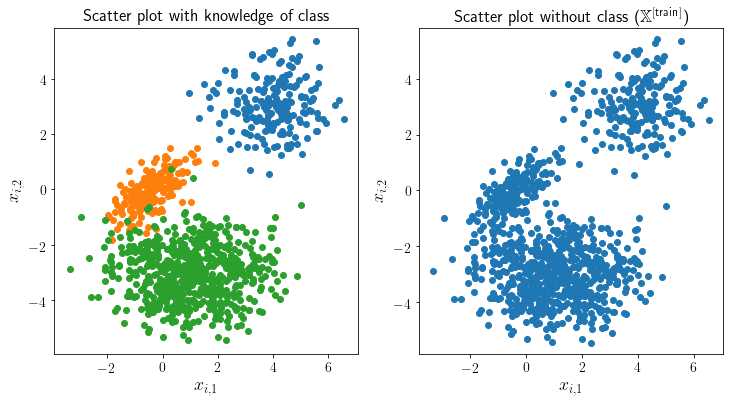

In [3]:
length = 1000

occur = np.random.rand(length)
tpi = np.cumsum(np.append([0], weights))

examples = np.zeros((length, 2))

# generate examples
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{bm}']

plt.figure(1,figsize=(12,6))
plt.subplot(121)
for k in range(len(weights)):
    idx = (occur >= tpi[k]) & (occur < tpi[k+1])    
    x, y = np.random.multivariate_normal(means[k], covariances[k], sum(idx)).T
    plt.scatter(x,y)
    examples[idx,0] = x
    examples[idx,1] = y
plt.title('Scatter plot with knowledge of class')
plot_range = plt.axis('equal')
plt.xlabel('$x_{i,1}$', fontsize=18)
plt.ylabel('$x_{i,2}$', fontsize=18)

    
# shuffle examples
np.random.shuffle(examples)

plt.subplot(122)
plt.scatter(examples[:,0], examples[:,1])
plt.title('Scatter plot without class ($\mathbb{X}^{[\\textsf{train}]}$)')
plt.axis('equal')
plt.xlabel('$x_{i,1}$', fontsize=18)
plt.ylabel('$x_{i,2}$', fontsize=18)
#plt.savefig('GMM_m3_initial.pdf',bbox_inches='tight')
plt.show()

Helper functions to evaluate a multivariate normal distribution and plot a 2D Gaussian distribution using a contour plot.

In [4]:
# multivariate Gaussian pdf
# implemented such that x can be an array with each row containing a different example x
def mvnorm(x, mu, sigma):
    D = len(mu)    
    temp = x-mu    
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)    
    
    result = np.dot(sigma_inv, temp.T)
    exponent = np.array([np.dot(temp[k,:],result[:,k]) for k in range(x.shape[0])])
    constant = np.sqrt(1 / ((2*math.pi)**D * sigma_det))
    return constant * np.exp(-0.5*exponent)

def plot_nice(mus, sigmas, pis, ax=None, title=None):
    ax = ax or plt.gca()
    xx, yy = np.mgrid[-ext_max:ext_max:200j, -ext_max:ext_max:200j]
    myinput = np.concatenate( (np.reshape(xx,(-1,1)), np.reshape(yy,(-1,1))), axis=1)
    f = pis[0]*mvnorm(myinput, mus[0], sigmas[0])
    for k in range(1,len(pis)):
        f += pis[k]*mvnorm(np.concatenate( (np.reshape(xx,(-1,1)), np.reshape(yy,(-1,1))), axis=1), mus[k], sigmas[k])
    f = np.reshape(f, xx.shape)
    
    ax.set_xlim(plot_range[0], plot_range[1])
    ax.set_ylim(plot_range[2], plot_range[3])
    cfset = ax.contourf(xx, yy, f, 20,cmap='coolwarm')
    ax.imshow(np.rot90(f), cmap='coolwarm', extent=[-ext_max, ext_max, -ext_max, ext_max])
    cset = ax.contour(xx, yy, f, 20, colors='k',linewidths=0.3)    
    ax.set_xlabel('$x_{i,1}$', fontsize=18)
    ax.set_ylabel('$x_{i,2}$', fontsize=18)
    ax.set_title(title)

In the following cell, we run the EM algorithm to fit a mixture of $m$ Gaussians to the data set. The EM algorithm can be summarized as
***
### The Expectation-Maximization Algorithm
1. Initialize $\boldsymbol{\mu}_\ell$, $\boldsymbol{\Sigma}_\ell$, $\pi_\ell$ and compute initial log-likelihood as $\mathcal{L}{(0)}$. Set iteration counter $I=1$
1. <font color=blue>__Expectation step__</font>: Evaluate, using the current $\boldsymbol{\mu}_\ell$, $\boldsymbol{\Sigma}_\ell$ and $\pi_\ell$
	\begin{equation*}
		\gamma(\boldsymbol{x}_i^{[\textsf{train}]},y_{i,\ell}) = \frac{\pi_\ell\mathcal{N}(\boldsymbol{x}_i^{[\textsf{train}]}; \boldsymbol{\mu}_\ell,\boldsymbol{\Sigma}_\ell)}{\sum_{k=1}^m\pi_k\mathcal{N}(\boldsymbol{x}_i^{[\textsf{train}]};\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}
	\end{equation*}
3. <font color=blue>__Maximization step__</font>: Re-estimate the parameters as
	\begin{align*}
		\boldsymbol{\mu}_\ell^{\textsf{new}} &= \frac{1}{N_\ell}\sum_{i=1}^N\gamma(\boldsymbol{x}_i^{[\textsf{train}]}, y_{i,\ell})\boldsymbol{x}_i^{[\textsf{train}]}\\        
		\boldsymbol{\Sigma}_\ell^{\textsf{new}} &= \frac{1}{N_\ell}\sum_{i=1}^N\gamma(\boldsymbol{x}_i^{[\textsf{train}]}, y_{i,\ell})(\boldsymbol{x}_i^{[\textsf{train}]}-\boldsymbol{\mu}_\ell^{\textsf{new}})(\boldsymbol{x}_i^{[\textsf{train}]}-\boldsymbol{\mu}_\ell^{\textsf{new}})^{\mathrm{T}} \\
        \pi_\ell^{\textsf{new}} &= \frac{N_\ell}{N}
	\end{align*}
	where
    \begin{equation*}
        N_\ell = \sum\limits_{i=1}^N\gamma(\boldsymbol{x}_i^{[\textsf{train}]}, y_{i,\ell})
    \end{equation*}
4. Evaluate the log-likelihood 
    \begin{equation*}
        \mathcal{L}^{(I)} = \sum\limits_{i=1}^N\log\left(\sum\limits_{\ell=1}^m\pi_\ell\mathcal{N}(\boldsymbol{x}_i^{[\textsf{train}]};\boldsymbol{\mu}_\ell,\boldsymbol{\Sigma}_\ell)\right)
    \end{equation*}	
	If $|\mathcal{L}^{(I)}-\mathcal{L}^{(I-1)}|<\epsilon$ abort, otherwise go to step 2. ($\epsilon$: small constant)
***    

Breaking after 24 iterations as likelihood converged

Obtained means after expectation maximization:
[array([3.98976352, 3.02945584]), array([-0.44018462, -0.06002326]), array([ 1.00723478, -3.02925762])]

Obtained covariance matrices after expectation maximization:
[[0.98614523 0.05104274]
 [0.05104274 0.85598925]]
[[0.5007646  0.32897287]
 [0.32897287 0.43740886]]
[[ 2.09906751 -0.01239689]
 [-0.01239689  0.95588399]]

Obtained weights after expectation maximization:
[0.20377479 0.18430175 0.61192346]


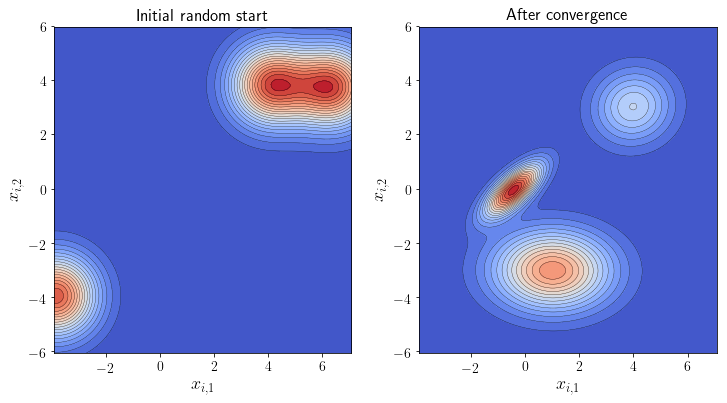

In [5]:
# number of classes
m = 3

# needed for plotting
ext_max = 1.2*np.max(np.max(np.abs(examples),axis=0))

# randomly distribute initial means so that they lie somewhere within plotting area
mus = [[np.random.uniform(low=plot_range[0], high=plot_range[1]), np.random.uniform(low=plot_range[2], high=plot_range[3])] for k in range(m)]

# start with unit covariance matrices
sigmas = [np.eye(2) for k in range(m)]

# assume that each class is used equally often
pis = np.ones(m)/m

# maximum number of iterations
max_iterations = 200

# number of examples N
N = examples.shape[0]

# initialize space for gammas
gammas = np.zeros((N,m))

# assume that log-likelihood is -infinity before starting
init_log_likelihood = -np.Inf

_, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
plot_nice(mus, sigmas, pis, ax1, 'Initial random start')


# carry out EM algorithm
for iter in range(max_iterations):

    # E-step, compute gammas
    for k in range(m):        
        gammas[:,k] = pis[k] * mvnorm(examples, mus[k], sigmas[k])
    summe = np.sum(gammas, axis=1)
    gammas = gammas / summe[:,np.newaxis]
            
    # M-step, re-optimize parameters
    Nk = np.sum(gammas,axis=0)
    for k in range(m):
        # maximize means
        mus[k] = np.sum(examples * np.tile(gammas[:,k], (2,1)).T, axis=0) / Nk[k]
        
        # maximize covariance matrices
        sigmas[k] = np.zeros((2,2))
        for n in range(N):
            sigmas[k] += gammas[n,k] * np.outer(examples[n,:]-mus[k], examples[n,:]-mus[k])
        sigmas[k] = sigmas[k] / Nk[k]
        
        # maximize weights
        pis[k] = Nk[k] / N

    # compute log-likelihood
    lsumme = np.zeros(N)
    for k in range(m):
        lsumme += pis[k]*mvnorm(examples, mus[k], sigmas[k])
    log_likelihood = np.sum(np.log(lsumme))
    
    # stopping criterion
    if abs(log_likelihood-init_log_likelihood) < 1e-4:
        print('Breaking after %d iterations as likelihood converged' % iter)
        break
    init_log_likelihood = log_likelihood    
    
# output
plot_nice(mus, sigmas, pis, ax2, 'After convergence')
#plt.savefig('GMM_m3_afterconvergence.pdf',bbox_inches='tight')
print('\nObtained means after expectation maximization:')
print(mus)
print('\nObtained covariance matrices after expectation maximization:')
[print(sigmas[k]) for k in range(m)]
print('\nObtained weights after expectation maximization:')
print(pis)

Plot another scatter plot, but this time take the examples and use the corresponding $\gamma(\boldsymbol{x}_i^{[\textsf{train}]}, y_{i,\ell)$ to interpolate between the colors. If we compare this scatter plot with the above one, we can see that some points are incorrectly classified (some points of the "bottom" cluster are within the tilted cluster. The algorithm cannot distinguish if these points belong the bottom cluster but rather assume that they are close to the nearest one

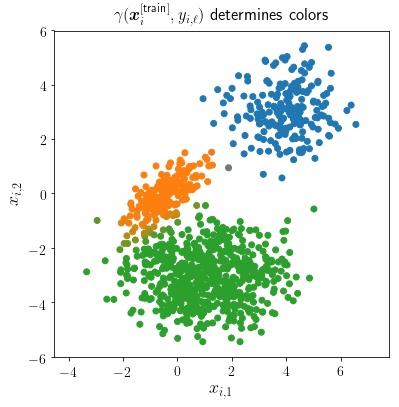

In [6]:
cmap = plt.get_cmap("tab10")

colors = np.zeros((N,3))

for k in range(m):
    for n in range(N):
        colors[n,:] += np.multiply(gammas[n,k],list(cmap(k))[0:3])

np.clip(colors,0,1)        
plt.figure(1,figsize=(6,6))
plt.scatter(examples[:,0], examples[:,1], c=colors)
plt.title('$\gamma(\\bm{x}_i^{[\\textsf{train}]},y_{i,\ell})$ determines colors')
plt.axis('equal')
plt.xlabel('$x_{i,1}$', fontsize=18)
plt.ylabel('$x_{i,2}$', fontsize=18)
#plt.savefig('GMM_m3_scattercolored.pdf',bbox_inches='tight')

***
Generate videos showing the convergence of the EM algorithm

<IPython.core.display.Javascript object>


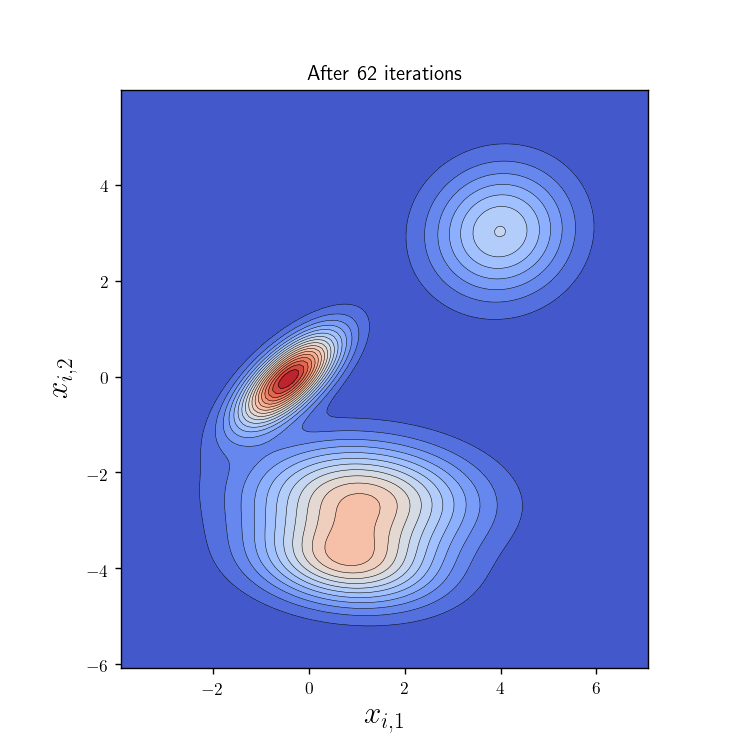

In [12]:
%matplotlib notebook
# Generate animation
from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.


np.random.seed(200)

# less examples to have slower convergence
new_examples = False
if new_examples == True:    
    ani_length = 300
    examples = np.zeros((ani_length, 2))
    occur = np.random.rand(ani_length)
    for k in range(len(weights)):
        idx = (occur >= tpi[k]) & (occur < tpi[k+1])    
        examples[idx,0], examples[idx,1]  = np.random.multivariate_normal(means[k], covariances[k], sum(idx)).T    

m = 4
# randomly distribute initial means so that they lie somewhere within plotting area
mus = [[np.random.uniform(low=plot_range[0], high=plot_range[1]), np.random.uniform(low=plot_range[2], high=plot_range[3])] for k in range(m)]

# start with unit covariance matrices
sigmas = [0.5*np.eye(2) for k in range(m)]

# assume that each class is used equally often
pis = np.ones(m)/m

# maximum number of iterations
max_iterations = 200

# number of examples N
N = examples.shape[0]

# initialize space for gammas
gammas = np.zeros((N,m))

# assume that log-likelihood is -infinity before starting
init_log_likelihood = -np.Inf

fig, ax = plt.subplots(1, figsize=(6,6))
#plot_nice(mus, sigmas, pis, ax, 'After 0 iterations')
#plt.show()

written = False
def animate(i):
    global gammas, mus, sigmas, pis, init_log_likelihood, written

    ax.clear()
    plot_nice(mus, sigmas, pis, ax, 'After %d iterations' % (i))

    if i==0:
        return
    
    # E-step
    for k in range(m):        
        gammas[:,k] = pis[k] * mvnorm(examples, mus[k], sigmas[k])
    summe = np.sum(gammas, axis=1)
    gammas = gammas / summe[:,np.newaxis]
            
    # M-step
    Nk = np.sum(gammas,axis=0)
    for k in range(m):
        # maximize means
        mus[k] = np.sum(examples * np.tile(gammas[:,k], (2,1)).T, axis=0) / Nk[k]
        
        # maximize covariance matrices
        sigmas[k] = np.zeros((2,2))
        for n in range(N):
            sigmas[k] += gammas[n,k] * np.outer(examples[n,:]-mus[k], examples[n,:]-mus[k])
        sigmas[k] = sigmas[k] / Nk[k]
        
        # maximize weights
        pis[k] = Nk[k] / N

    # compute log-likelihood
    lsumme = np.zeros(N)
    for k in range(m):
        lsumme += pis[k]*mvnorm(examples, mus[k], sigmas[k])
    log_likelihood = np.sum(np.log(lsumme))
    
    
    # stopping criterion
    if abs(log_likelihood-init_log_likelihood) < 1e-4 and not written:
        print('Breaking after %d iterations as likelihood converged' % i)        
        written = True
    init_log_likelihood = log_likelihood    
       

    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=200, blit=False)
fig.show()
#anim.save('expectation_maximation_for_GMMs.gif', writer=PillowWriter(fps=10))